# Home Value Prediction
Project Goals
- Identify drivers of home value of single family homes
- Build a model from those drivers to predict value
- Examine oppotunities for improvement

Imports

In [2]:
import pandas as pd
import numpy as np
import wrangle_zillow as wrangle
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

# feature selection:
from sklearn.feature_selection import SelectKBest, RFE, f_regression

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# get data

The dataset used in this project is Zillow data from 2017. 

It contains 2,142,803 rows representing single family properties in LA, Orange, and Ventura County California. 

The features of the dataset include bedrooms, bathrooms, area, year built, and FIPS code.

In [78]:
#run this cell if you don't have a zillow csv file
#zillow = wrangle.aqcuire_zillow()

In [3]:
#Run this cell if you have a zillow csv file
zillow = pd.read_csv('zillow.csv')

In [46]:
zillow.columns

Index(['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built', 'fips'], dtype='object')

# Feature Engineering
- 'age'= 2017 - 'year_built'
    - bulit in this feature for ease of explainability and readability
- we can also remap fips to represent the county the properties are located in:
    - fips county,state
    - 6037 Los Angeles County, California
    - 6059 Orange County, California
    - 6111 Ventura County, California

In [50]:
#create 'age'
zillow['age'] = 2017 - zillow.year_built
# create a mapping between fips codes and their county
#fips_name_map = {6037: 'LA', 6059: 'Orange', 6111: 'Ventura'}
# use map() method to remap fips codes to names
#zillow['fips'] = zillow['fips'].map(fips_name_map)


### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
| **bathroooms** | The number of bathrooms in the home. |*float*|
| **bedrooms** | The number of bedrooms in the home.|*float*|
|**area**| Square footage of the house| *int*|
|**year_built**| Year the house was built| *int*|
|**fips**| fips code of the county where the house is located| *float*|
|**age**| Age of the house in 2017| *int*|
|**tax_value**| The tax-assessed value of the home. | *float* |

In [4]:
#eliminates 12 properties built in 2017
zillow.dropna(inplace=True)

# Preparation
- remove duplicates
- imput means to fill nulls
- remove outliers
- train validate test split

In [81]:
train, validate, test = wrangle.prepare_zillow(zillow)

In [82]:
train.shape, validate.shape, test.shape

((1054975, 7), (452133, 7), (376778, 7))

# Initial thoughts:
# Area and age will have the biggest influence on tax_value

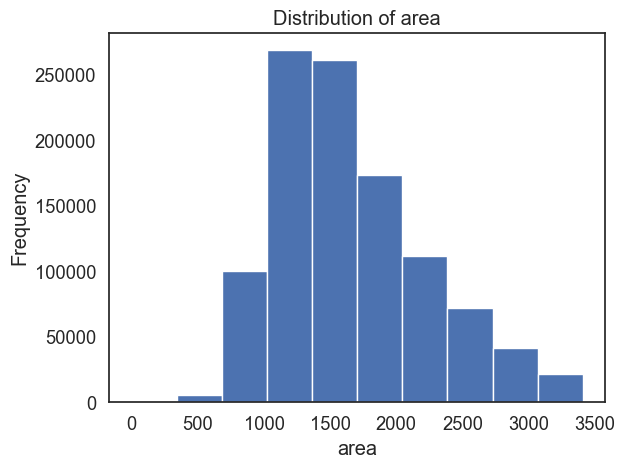

In [54]:
evaluate.show_distribution(train,'area')

$H_0$: area does not influence tax value

$H_a$: area does influence tax value

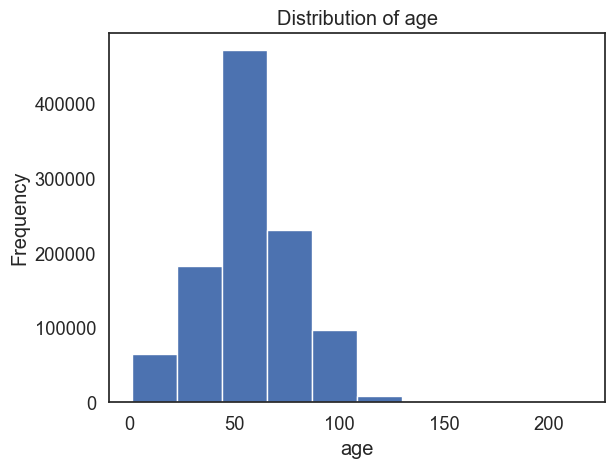

In [55]:
evaluate.show_distribution(train, 'age')

$H_0$: age does not influence tax value

$H_a$: age does influence tax value

these are both pretty normally distributed so we'll just use pearson's R to get P values and coor coef for the features
our Pvalues are lower than .05 so age and area do influence tax value

In [56]:
evaluate.print_corr_table(train,'tax_value')

Correlation Coefficients and P-Values:
            corr_coef  p_value
tax_value        1.00     0.00
area             0.44     0.00
bathrooms        0.36     0.00
age             -0.25     0.00
year_built       0.25     0.00
bedrooms         0.20     0.00
fips              NaN     0.00


lets look at fips encoded as well

In [71]:
evaluate.print_corr_table(pd.get_dummies(train),'tax_value')

Correlation Coefficients and P-Values:
             corr_coef  p_value
tax_value         1.00     0.00
lm_preds          0.45     0.00
area              0.44     0.00
bathrooms         0.36     0.00
age              -0.25     0.00
year_built        0.25     0.00
bedrooms          0.20     0.00
fips_6037.0      -0.17     0.00
fips_6059.0       0.15     0.00
fips_6111.0       0.04     0.00


# looks like there is a correlation between fips and tax value that we can investigate later

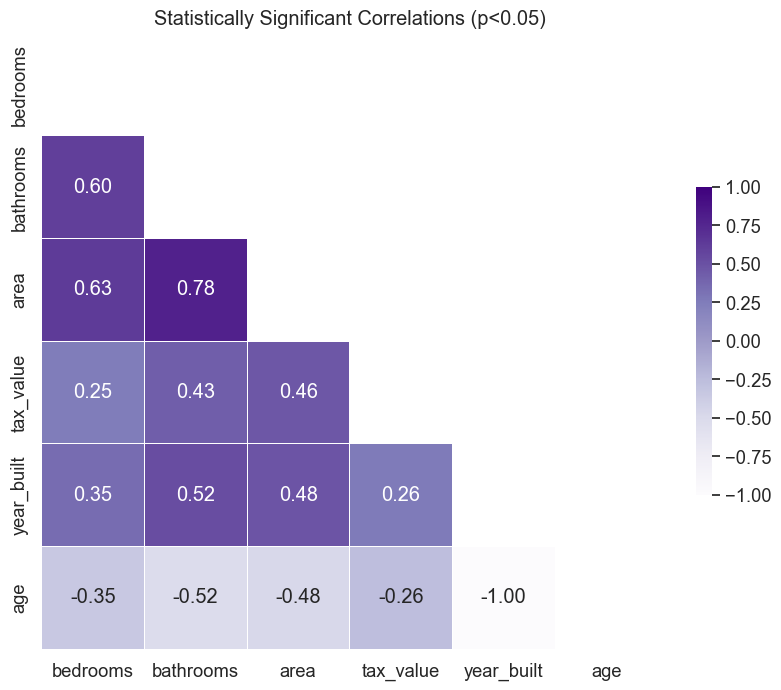

In [57]:
evaluate.visualize_corr(train.sample(1000).drop(columns='fips'))

In [58]:
X_train = train.sample(1000,random_state=42).drop(columns=['tax_value'])
y_train = train.sample(1000,random_state=42).tax_value
X_test = test.sample(100,random_state=42).drop(columns=['tax_value'])
y_test = test.sample(100,random_state=42).tax_value

lets see if we're on the right track

In [59]:
evaluate.select_kbest(X_train,y_train,k=2)

['bathrooms', 'area']

In [67]:
evaluate.rfe(X_train,y_train,k=3)

['bathrooms', 'year_built', 'age']

Hmm bathrooms keep popping up, lets make a note of that to engineer a feature in the future.

okay since tax value is dependent on all of the features in the data set 
we'll use them all in our modeling

lets run a lazy predict to find what model we should use

In [61]:
reg = LazyRegressor(predictions=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:15<00:00,  2.63it/s]


In [62]:
print(models)

                               Adjusted R-Squared  R-Squared        RMSE  \
Model                                                                      
OrthogonalMatchingPursuitCV                  0.21       0.26   204526.63   
SGDRegressor                                 0.21       0.26   204610.81   
KernelRidge                                  0.20       0.25   205804.83   
TransformedTargetRegressor                   0.20       0.25   205881.06   
LinearRegression                             0.20       0.25   205881.06   
Lasso                                        0.20       0.25   205882.07   
LassoCV                                      0.20       0.25   205884.78   
Ridge                                        0.20       0.25   205886.86   
RidgeCV                                      0.20       0.25   205943.29   
BayesianRidge                                0.20       0.25   206036.27   
AdaBoostRegressor                            0.20       0.25   206526.32   
LassoLarsIC 

looks like a linear regressor is going to work pretty well, lets set up the model on the whole training set

In [72]:
X_train = train.drop(columns=['tax_value'])
y_train = train.tax_value
X_val = validate.drop(columns=['tax_value'])
y_val = validate.tax_value
X_test = test.drop(columns=['tax_value'])
y_test = test.tax_value

In [64]:
# OLS = ordinary least squares

# MAKE THE THING: create the model object
lm = LinearRegression()

# FIT THE THING: fit the model to training data
lm.fit(X_train, y_train)

# USE THE THING: make a prediction
train['lm_preds'] = lm.predict(X_train)

In [65]:
#Training
evaluate.better_than_baseline(train.tax_value,train.lm_preds)

Model outperformed the baseline.
R-squared (model): 0.2050
R-squared (baseline): 0.0000
RMSE (model): 184565.4004
RMSE (baseline): 206999.8079


In [74]:
#validate
evaluate.better_than_baseline(validate.tax_value,lm.predict(X_val))

Model outperformed the baseline.
R-squared (model): 0.2045
R-squared (baseline): 0.0000
RMSE (model): 184932.4172
RMSE (baseline): 207345.4233


In [75]:
#test
evaluate.better_than_baseline(test.tax_value,lm.predict(X_test))

Model outperformed the baseline.
R-squared (model): 0.2035
R-squared (baseline): 0.0000
RMSE (model): 184786.2897
RMSE (baseline): 207052.9389


# our model is outperforming baseline by about 20%

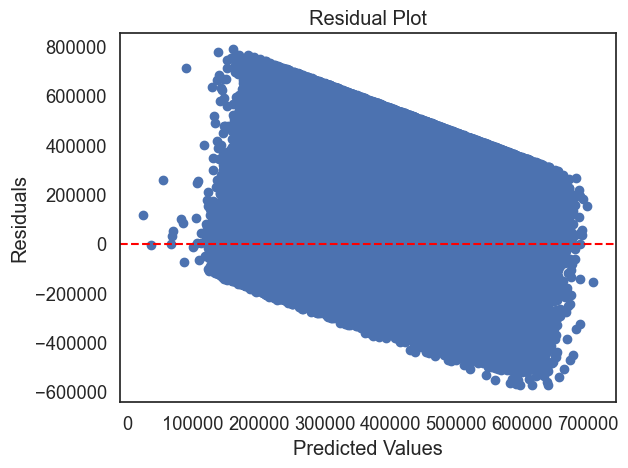

In [66]:
evaluate.plot_residuals(train.tax_value, train.lm_preds)

looks like we've pretty evenly split our data but this isn't exactly killing it

# Recommendations:
- Create a new feature that combines bedrooms and bathrooms into one metric
    - this will improve the correlation of the one value
- Encode fips and build separate models for predicting values in each county
    - this may improve the model performace
- Imput median values for missing data

# Conclusion
- tax value is at least a little bit dependent on all of the features selected 
- fiding a new metric to improve the correlation will improve the model
- current order of importance:
    - Area
    - Bathrooms
    - Age
- using a linear regression model our predictions will improve by about 20%